# Face Recognition using Support Vector Machine (SVM)

## Educational Tutorial

This notebook demonstrates how to build a face recognition system using SVM and OpenCV.

### Learning Objectives:
1. Understand Support Vector Machines (SVM)
2. Learn face detection techniques
3. Extract facial features using HOG
4. Train and evaluate SVM classifier
5. Deploy as a web application

## 1. Setup and Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
from skimage import exposure
import seaborn as sns
import os
import joblib
from pathlib import Path

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Understanding Support Vector Machine (SVM)

### What is SVM?

Support Vector Machine is a supervised learning algorithm that:
1. **Finds the optimal hyperplane** that separates different classes
2. **Maximizes the margin** between classes
3. **Handles non-linear data** using kernel tricks

### Why SVM for Face Recognition?
- Works well with high-dimensional feature spaces
- Effective with limited training data
- Provides good generalization
- Interpretable decision boundaries

## 3. Face Detection

We'll use Haar Cascade classifier for face detection.

In [2]:
class FaceDetector:
    """Face detection using Haar Cascade"""
    
    def __init__(self):
        cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        self.face_cascade = cv2.CascadeClassifier(cascade_path)
    
    def detect_faces(self, image):
        """Detect faces in image"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )
        return faces
    
    def extract_face_roi(self, image, face_rect, padding=10):
        """Extract face region of interest"""
        x, y, w, h = face_rect
        x = max(0, x - padding)
        y = max(0, y - padding)
        face_roi = image[y:y+h+padding*2, x:x+w+padding*2]
        return face_roi

# Initialize detector
detector = FaceDetector()
print("✓ Face detector initialized")

✓ Face detector initialized


## 4. Feature Extraction

We'll extract HOG (Histogram of Oriented Gradients) features from faces.

In [3]:
class FeatureExtractor:
    """Extract facial features using HOG"""
    
    def __init__(self, image_size=(128, 128)):
        self.image_size = image_size
    
    def preprocess_face(self, face_image):
        """Preprocess face image"""
        # Resize
        face = cv2.resize(face_image, self.image_size)
        
        # Convert to grayscale
        if len(face.shape) == 3:
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        
        # Histogram equalization
        face = cv2.equalizeHist(face)
        
        return face
    
    def extract_hog_features(self, face_image):
        """Extract HOG features"""
        face = self.preprocess_face(face_image)
        
        features, _ = hog(
            face,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            block_norm='L2-Hys'
        )
        
        return features

# Initialize extractor
extractor = FeatureExtractor(image_size=(128, 128))
print("✓ Feature extractor initialized")

✓ Feature extractor initialized


## 5. Data Preparation

### Expected Directory Structure:
```
data/raw/
├── person1/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── person2/
│   ├── image1.jpg
│   └── ...
└── ...
```

In [4]:
def load_training_data(data_dir):
    """Load training data from directory"""
    features_list = []
    labels_list = []
    
    person_dirs = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    
    print(f"Found {len(person_dirs)} person(s)")
    
    for person_name in person_dirs:
        person_path = os.path.join(data_dir, person_name)
        image_files = [f for f in os.listdir(person_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        print(f"\nProcessing {person_name}: {len(image_files)} images")
        
        for img_file in image_files:
            try:
                img_path = os.path.join(person_path, img_file)
                image = cv2.imread(img_path)
                
                if image is None:
                    continue
                
                # Detect faces
                faces = detector.detect_faces(image)
                
                if len(faces) == 0:
                    continue
                
                # Use largest face
                face_rect = max(faces, key=lambda r: r[2] * r[3])
                face_roi = detector.extract_face_roi(image, face_rect)
                
                # Extract features
                features = extractor.extract_hog_features(face_roi)
                
                features_list.append(features)
                labels_list.append(person_name)
                
            except Exception as e:
                print(f"Error processing {img_file}: {str(e)}")
                continue
    
    X = np.array(features_list)
    y = np.array(labels_list)
    
    print(f"\nTotal samples: {len(X)}")
    print(f"Feature dimension: {X.shape[1]}")
    
    return X, y

# Load data
data_dir = '../data/raw'
if os.path.exists(data_dir):
    X, y = load_training_data(data_dir)
    print("\n✓ Data loaded successfully")
else:
    print(f"⚠ Data directory not found: {data_dir}")
    print("Please create the directory and add training images")

Found 2 person(s)

Processing Thathsara: 10 images

Processing Sachintha: 20 images

Total samples: 30
Feature dimension: 8100

✓ Data loaded successfully


## 6. Data Preprocessing

In [5]:
# Normalize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Classes: {list(label_encoder.classes_)}")
print(f"Feature shape: {X_scaled.shape}")
print(f"Label shape: {y_encoded.shape}")

Classes: [np.str_('Sachintha'), np.str_('Thathsara')]
Feature shape: (30, 8100)
Label shape: (30,)


## 7. Train-Test Split

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Train/Test ratio: {len(X_train)/len(X_test):.2f}")

Training set: 24 samples
Test set: 6 samples
Train/Test ratio: 4.00


## 8. Train SVM Model

In [7]:
# Train SVM
print("Training SVM model...")
model = SVC(
    kernel='rbf',
    C=100.0,
    gamma='scale',
    probability=True,
    random_state=42
)

model.fit(X_train, y_train)
print("✓ Model training completed")

Training SVM model...
✓ Model training completed


## 9. Model Evaluation

In [8]:
# Predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=label_encoder.classes_))

Test Accuracy: 0.8333

Classification Report:
              precision    recall  f1-score   support

   Sachintha       0.80      1.00      0.89         4
   Thathsara       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6



## 10. Confusion Matrix

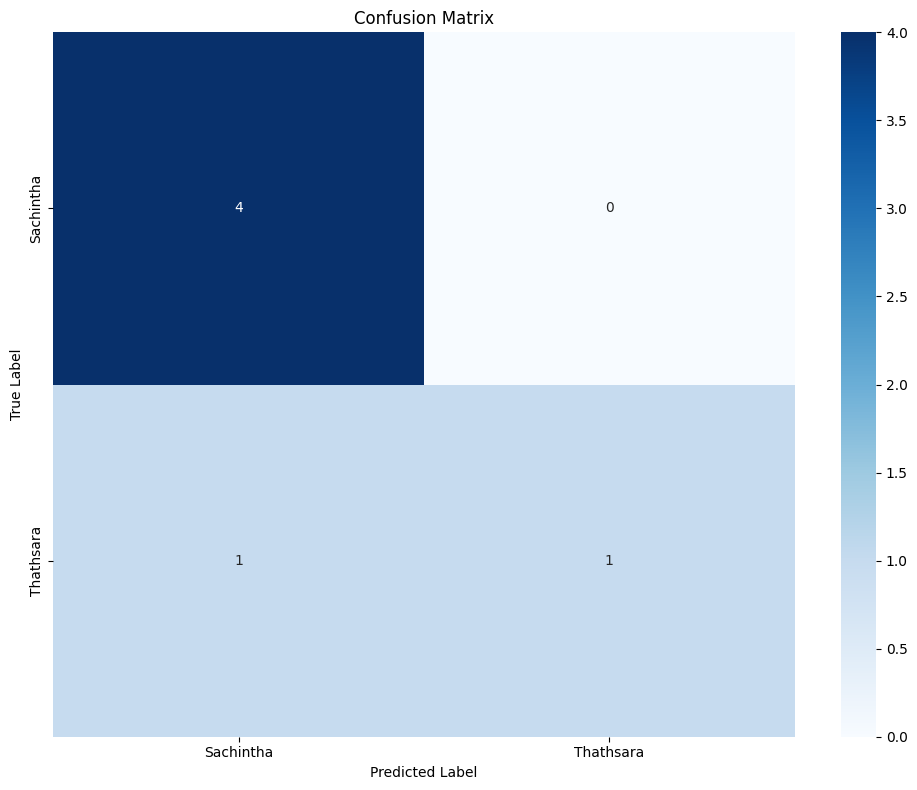

In [9]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 11. Save Model

In [10]:
# Create models directory
os.makedirs('../models', exist_ok=True)

# Save model
model_path = '../models/svm_face_recognition.pkl'
joblib.dump(model, model_path)

# Save metadata
metadata = {
    'label_encoder': label_encoder,
    'scaler': scaler,
    'accuracy': accuracy,
    'classes': list(label_encoder.classes_)
}
metadata_path = '../models/metadata.pkl'
joblib.dump(metadata, metadata_path)

print(f"✓ Model saved to {model_path}")
print(f"✓ Metadata saved to {metadata_path}")

✓ Model saved to ../models/svm_face_recognition.pkl
✓ Metadata saved to ../models/metadata.pkl


## 12. Test on New Image

In [11]:
def recognize_face_in_image(image_path, model, detector, extractor, label_encoder, scaler):
    """Recognize faces in an image"""
    
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image from {image_path}")
        return
    
    # Detect faces
    faces = detector.detect_faces(image)
    print(f"Detected {len(faces)} face(s)")
    
    # Process each face
    for i, face_rect in enumerate(faces):
        # Extract ROI
        face_roi = detector.extract_face_roi(image, face_rect)
        
        # Extract features
        features = extractor.extract_hog_features(face_roi)
        features = scaler.transform([features])
        
        # Predict
        label_idx = model.predict(features)[0]
        confidence = np.max(model.predict_proba(features))
        person_name = label_encoder.inverse_transform([label_idx])[0]
        
        print(f"\nFace {i+1}:")
        print(f"  Person: {person_name}")
        print(f"  Confidence: {confidence:.2%}")
    
    # Draw results
    image_copy = image.copy()
    for face_rect in faces:
        x, y, w, h = face_rect
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title('Face Recognition Results')
    plt.axis('off')
    plt.show()

# Example usage (uncomment when you have test images)
#test_path = os.path.join(data_dir, 'person_name/1_000.jpg')
#recognize_face_in_image(test_path, model, detector, extractor, label_encoder, scaler)

## 13. Summary

### What We Learned:

1. **Support Vector Machine (SVM)**
   - Powerful classifier for binary and multi-class problems
   - Works well with high-dimensional data
   - Kernel tricks enable non-linear classification

2. **Face Detection**
   - Haar Cascade classifier for fast face detection
   - Region of Interest (ROI) extraction

3. **Feature Extraction**
   - HOG (Histogram of Oriented Gradients) features
   - Captures edge and texture information
   - Robust to lighting changes

4. **Model Training & Evaluation**
   - Train-test split for proper evaluation
   - Accuracy, precision, recall metrics
   - Confusion matrix for detailed analysis

5. **Deployment**
   - Save trained models for production use
   - Web application with Streamlit

### Next Steps:
1. Collect more training data for better accuracy
2. Experiment with different kernels and parameters
3. Deploy to Streamlit Cloud
4. Add real-time webcam support